In [7]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import pandas as pd
import statsmodels.api as sm
from IPython.display import display, HTML

from statsmodels.regression.rolling import RollingOLS
from joblib import Parallel, delayed
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from matplotlib.backends.backend_svg import FigureCanvasSVG
from pandas.tseries.offsets import BDay
from sklearn.preprocessing import MinMaxScaler


from core.system import *
from core.operation import *
from class_model.prep_factor import PrepFactor 

import warnings

warnings.filterwarnings('ignore')

In [8]:
# Params
live = True
stock = read_stock(get_large(live) / 'permno_live.csv')
start = '2005-01-01'
window = 168
threshold = 2_000_000_000
past_date = (date.today() - timedelta(days=1)).strftime('%Y-%m-%d')
current_date = (date.today()).strftime('%Y-%m-%d')
past_date = '2023-11-09'
current_date = '2023-11-10'
format_end = date.today().strftime('%Y%m%d')
trial = f'mrev_{format_end}'
dir_path = Path(get_strat_mrev_etf() / 'report')
sbo = 0.85
sso = 0.85
sbc = 0.25
ssc = 0.25
etf_list = ['QQQ', 'XLE', 'XLV', 'VNQ', 'XLB', 'XLF', 'XLY', 'XLI', 'XLI', 'XLU', 'XLP']

In [9]:
def create_multi_index(factor_data, stock):
    factor_values = pd.concat([factor_data] * len(stock), ignore_index=True).values
    multi_index = pd.MultiIndex.from_product([stock, factor_data.index])
    multi_index_factor = pd.DataFrame(factor_values, columns=factor_data.columns, index=multi_index)
    multi_index_factor.index = multi_index_factor.index.set_names(['permno', 'date'])
    return multi_index_factor

# Past

In [10]:
# Find correlation between returns
def corr(df):
    # Unstack the DataFrame to get ticker returns in separate columns
    unstacked_df = df.unstack(level='ticker')
    returns_df = unstacked_df['RET_01']

    # Calculate the correlation matrix
    correlation_matrix = returns_df.corr()

    # Print pairwise correlations
    tickers = correlation_matrix.columns
    for i in range(len(tickers)):
        for j in range(i+1, len(tickers)):
            print(f"Correlation between {tickers[i]} and {tickers[j]}: {correlation_matrix.iloc[i, j]:.4f}")

In [11]:
# Read in ETF data from FMP
T = [1]
sector_ret_past = get_data_fmp(ticker_list=etf_list, start=start, current_date=past_date)
sector_ret_past = sector_ret_past[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_past = sector_ret_past.rename(columns={'Adj Close': 'Close'})
sector_ret_past = sector_ret_past.loc[~sector_ret_past.index.duplicated(keep='first')]
# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_past = create_return(sector_ret_past, T)
corr(sector_ret_past)
sector_ret_past = sector_ret_past.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_past = sector_ret_past.unstack('ticker').swaplevel(axis=1)
sector_ret_past.columns = ['_'.join(col).strip() for col in sector_ret_past.columns.values]
sector_ret_past = sector_ret_past.fillna(0)

Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.16ticker/s]

Correlation between QQQ and VNQ: 0.6539
Correlation between QQQ and XLB: 0.7580
Correlation between QQQ and XLE: 0.5826
Correlation between QQQ and XLF: 0.6985
Correlation between QQQ and XLI: 0.7939
Correlation between QQQ and XLP: 0.6760
Correlation between QQQ and XLU: 0.5381
Correlation between QQQ and XLV: 0.7490
Correlation between QQQ and XLY: 0.8769
Correlation between VNQ and XLB: 0.6646
Correlation between VNQ and XLE: 0.5329
Correlation between VNQ and XLF: 0.7952
Correlation between VNQ and XLI: 0.7148
Correlation between VNQ and XLP: 0.6203
Correlation between VNQ and XLU: 0.6039
Correlation between VNQ and XLV: 0.5765
Correlation between VNQ and XLY: 0.7246
Correlation between XLB and XLE: 0.7573
Correlation between XLB and XLF: 0.7366
Correlation between XLB and XLI: 0.8667
Correlation between XLB and XLP: 0.6516
Correlation between XLB and XLU: 0.5797
Correlation between XLB and XLV: 0.6891
Correlation between XLB and XLY: 0.7617
Correlation between XLE and XLF: 0.6305


In [13]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
past_data = pd.read_parquet(get_parquet(live) / 'data_price.parquet.brotli')
factor_col_past = sector_ret_past.columns
past_data = create_return(past_data, T)
past_data = past_data.fillna(0)

In [14]:
# Execute Rolling LR
beta_data_past = rolling_ols_parallel(data=past_data, ret=ret, factor_data=sector_ret_past, factor_cols=factor_col_past.tolist(), window=window, name=f'sector_01')

In [15]:
# Retrieve Needed Data
beta_data_past = beta_data_past[beta_data_past.columns[1:14]]
beta_data_past = beta_data_past.fillna(0)

In [16]:
# Calculate rolling mean and standard deviation
rolling_mean = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = beta_data_past.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
beta_data_past['s_score'] = (beta_data_past[f'epsil_sector_01_{window:02}'] - rolling_mean) / rolling_std

In [17]:
# # Export data
# beta_data_past.to_parquet(get_strategy_mrev_etf_data() / 'data_beta_etf.parquet.brotli', compression='brotli')

In [18]:
tsla = get_stock_data(beta_data_past, 10104)

<AxesSubplot:xlabel='permno,date'>

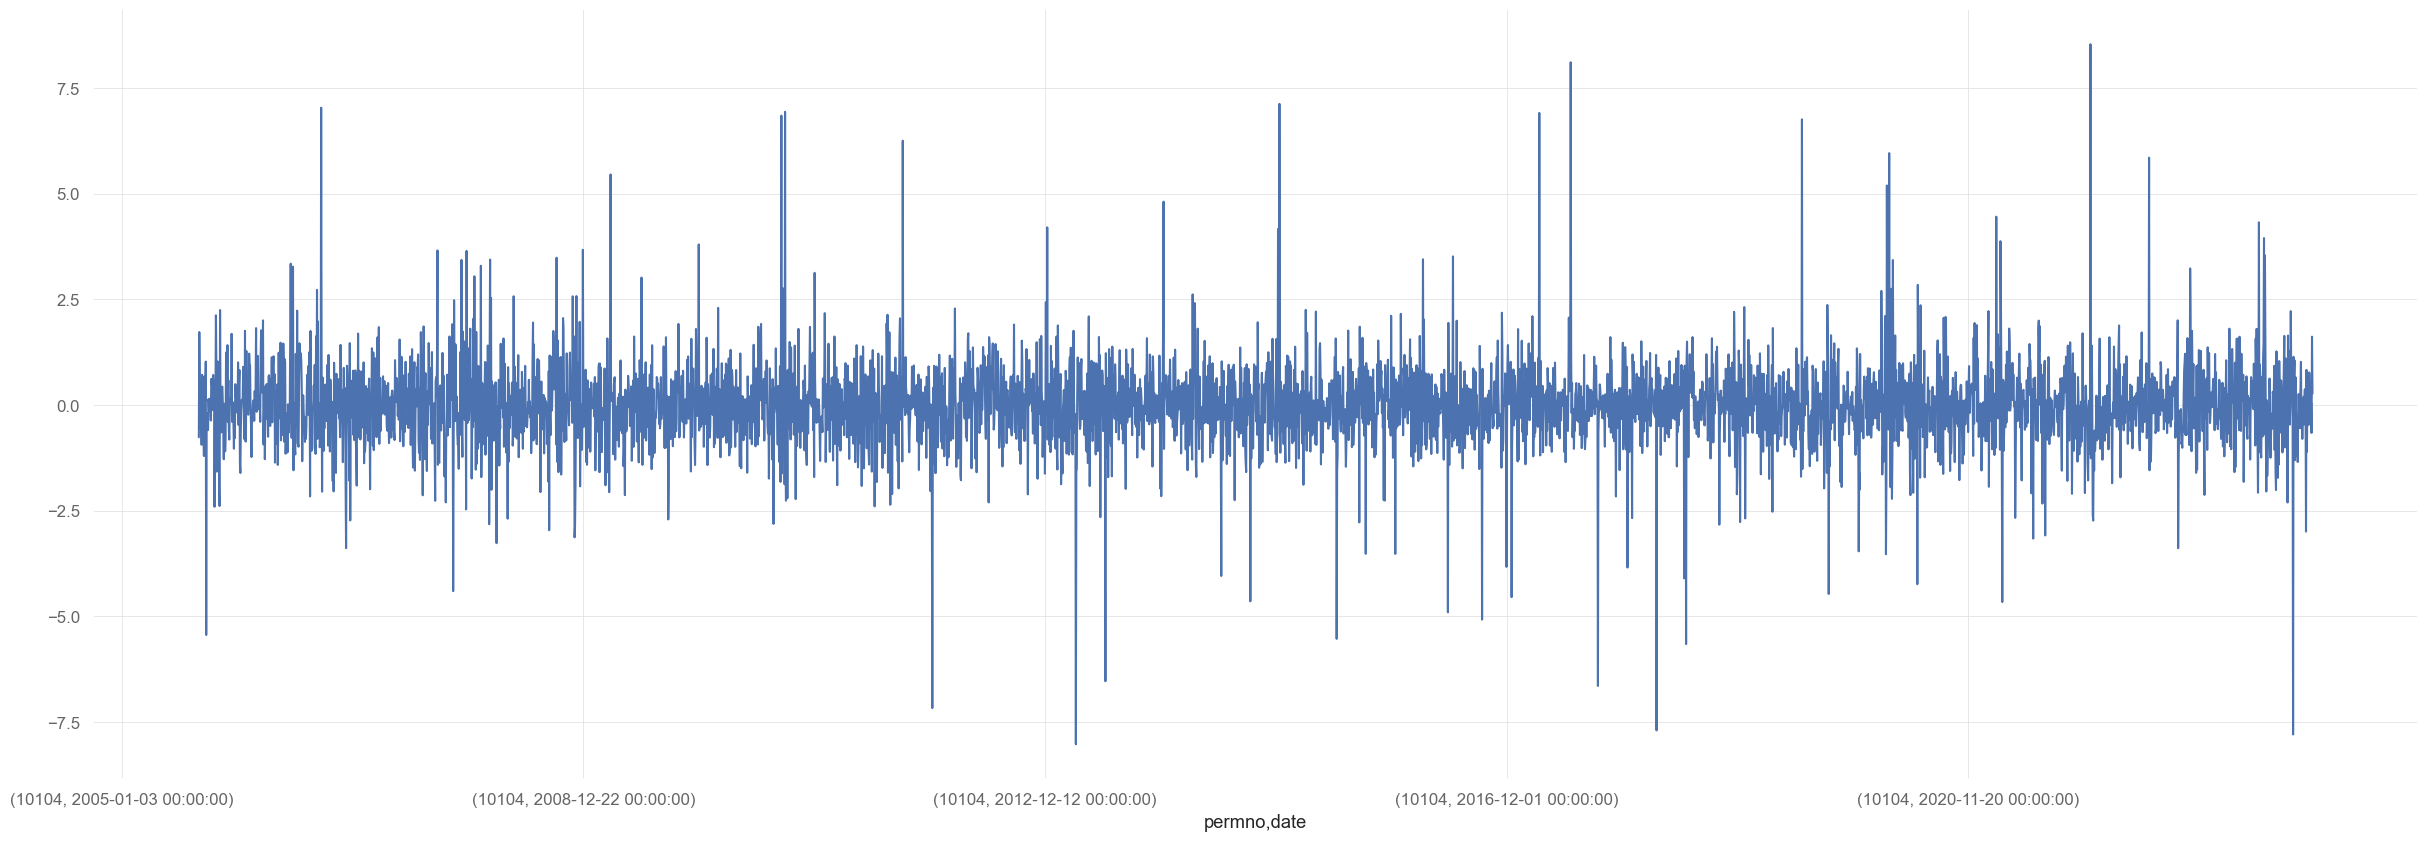

In [19]:
tsla.s_score.plot(figsize=(30, 10))

In [20]:
# Convert ETF Dataframe to multi-index
stock = read_stock(get_large(live) / 'permno_live.csv')
sector_multi_past = create_multi_index(sector_ret_past, stock)
# Merge the necessary columns together into one dataframe
combined_past = beta_data_past.merge(sector_multi_past, left_index=True, right_index=True, how='left')
combined_past = combined_past.merge(past_data[['RET_01']], left_index=True, right_index=True, how='left')
combined_past = combined_past.fillna(0)

In [21]:
# Retrieve the needed columns
ret_columns = [col for col in combined_past.columns if "RET_01" in col]
combined_past = combined_past[['s_score'] + ret_columns]

In [22]:
def create_signal_past(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        # Initialize signals and positions
        signals = [None] * len(group)
        positions = [None] * len(group)
        # Create masks for conditions
        open_long_condition = (group['s_score'] < -sbo) & (group['market_cap'] > threshold)
        open_short_condition = (group['s_score'] > sso) & (group['market_cap'] > threshold)
        close_long_condition = group['s_score'] > -ssc
        close_short_condition = group['s_score'] < sbc
        # Flag to check if any position is open
        position_open = False
        current_position = None
        
        for i in range(len(group)):
            if position_open:
                if positions[i-1] == 'long' and close_long_condition.iloc[i]:
                    signals[i] = 'close long'
                    positions[i] = None
                    position_open = False
                    current_position = None
                elif positions[i-1] == 'short' and close_short_condition.iloc[i]:
                    signals[i] = 'close short'
                    positions[i] = None
                    position_open = False
                    current_position = None
                else:
                    signals[i] = 'hold'
                    positions[i] = current_position
            else:
                if open_long_condition.iloc[i]:
                    positions[i] = 'long'
                    signals[i] = 'buy to open'
                    current_position = 'long'
                    position_open = True
                elif open_short_condition.iloc[i]:
                    positions[i] = 'short'
                    signals[i] = 'sell to open'
                    position_open = True
                    current_position = 'short'

        return pd.DataFrame({'signal': signals, 'position': positions}, index=group.index)

    # Sort data
    data = data.sort_index(level=['permno', 'date'])
    # Group by permno and apply the rules for each group
    results = data.groupby('permno').apply(apply_rules).reset_index(level=0, drop=True)
    # Flatten the results and assign back to the data
    data = data.join(results)
    return data

In [23]:
# Create signals
copy = combined_past.copy(deep=True)
misc = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
copy = copy.merge(misc, left_index=True, right_index=True, how='left')
result_past = create_signal_past(copy, sbo, sso, sbc, ssc, threshold)

In [24]:
tsla = get_stock_data(beta_data_past, 93436)

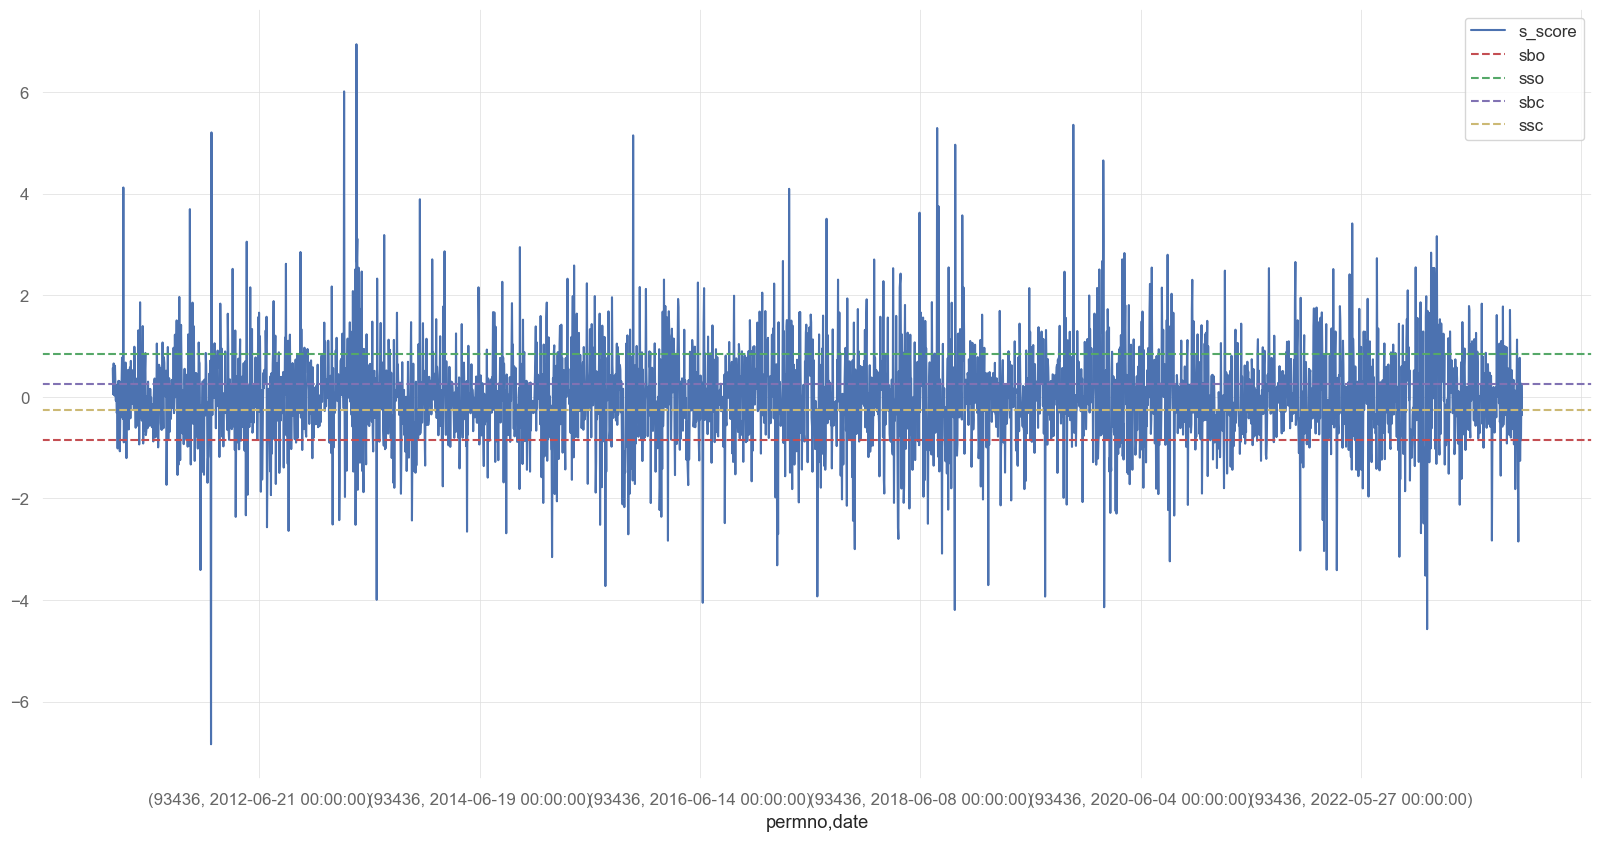

In [25]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 10))
# Plot the s_score
tsla.s_score.plot(ax=ax)
# Plot the threshold lines
ax.axhline(y=-sbo, color='r', linestyle='--', label='sbo')
ax.axhline(y=sso, color='g', linestyle='--', label='sso')
ax.axhline(y=sbc, color='m', linestyle='--', label='sbc')
ax.axhline(y=-ssc, color='y', linestyle='--', label='ssc')
# Add legend
ax.legend()
# Display the plot
plt.show()

In [26]:
def calc_total_ret(df, etf_returns):
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()
    
    # Combine and normalize weights
    print("Normalize weights...")
    df['stock_weight'] = np.where(mask_long, 1, np.where(mask_short, -1, 0))
    
    # Normalize net hedge betas and stock weights combined
    df['abs_stock_weight'] = df['stock_weight'].abs()
    combined_weights = df.groupby('date')['abs_stock_weight'].sum() + net_hedge_betas.abs().sum(axis=1)
    df['normalized_weight'] = df['stock_weight'].div(combined_weights, axis=0)
    normalized_net_hedge_betas = net_hedge_betas.div(combined_weights, axis=0)
    
    # Get net hedge return
    print("Get net hedge returns...")
    net_hedge_returns = pd.DataFrame(index=normalized_net_hedge_betas.index)
    for beta in beta_columns:
        etf_return_column = beta.split('_sector_')[0]
        if etf_return_column in etf_returns.columns:
            net_hedge_returns[beta] = normalized_net_hedge_betas[beta] * etf_returns[etf_return_column]
    
    # Get total hedge return
    print("Get total hedge return...")
    net_hedge_return_total = net_hedge_returns.sum(axis=1)
    
    print("Get daily returns...")
    daily_returns = (df['RET_01'] * df['normalized_weight']).groupby('date').sum()
    
    print("Get total returns...")
    total_returns = daily_returns + net_hedge_return_total
    
    return total_returns, daily_returns, net_hedge_return_total, normalized_net_hedge_betas, df[['normalized_weight']]

In [27]:
result_past_copy = result_past.copy(deep=True)

In [28]:
result_past_copy['RET_01'] = result_past_copy.groupby('permno')['RET_01'].shift(-1)

In [29]:
# Calculate strategy's return
ewp_ret, daily_ret, hedge_ret, beta_weight, stock_weight = calc_total_ret(result_past_copy, sector_ret_past.shift(-1))

Get hedge weights...
Get net hedge betas...
Normalize weights...
Get net hedge returns...
Get total hedge return...
Get daily returns...
Get total returns...


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-08-31   2005-08-31
End Period                 2023-11-09   2023-11-09
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          258.4%       403.04%
CAGR﹪                     4.96%        6.32%

Sharpe                     0.46         2.72
Prob. Sharpe Ratio         97.37%       100.0%
Smart Sharpe               0.42         2.49
Sortino                    0.64         4.4
Smart Sortino              0.58         4.03
Sortino/√2                 0.45         3.11
Smart Sortino/√2           0.41         2.85
Omega                      1.63         1.63

Max Drawdown               -56.47%      -6.15%
Longest DD Days            1982         584
Volatility (ann.)          19.66%       3.28%
R^2                        0.0          0.0
Information Ratio          -0.0         -0.0
Calmar                 

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-08-07,2020-03-17,2020-05-19,287,-6.154320,-5.571174
2,2021-01-04,2021-11-30,2022-08-10,584,-3.991713,-3.713931
3,2009-08-20,2009-09-18,2009-10-27,69,-3.428640,-3.366722
4,2009-12-01,2010-01-20,2010-02-08,70,-2.717730,-2.698070
5,2009-05-28,2009-06-10,2009-06-25,29,-2.204423,-2.057833


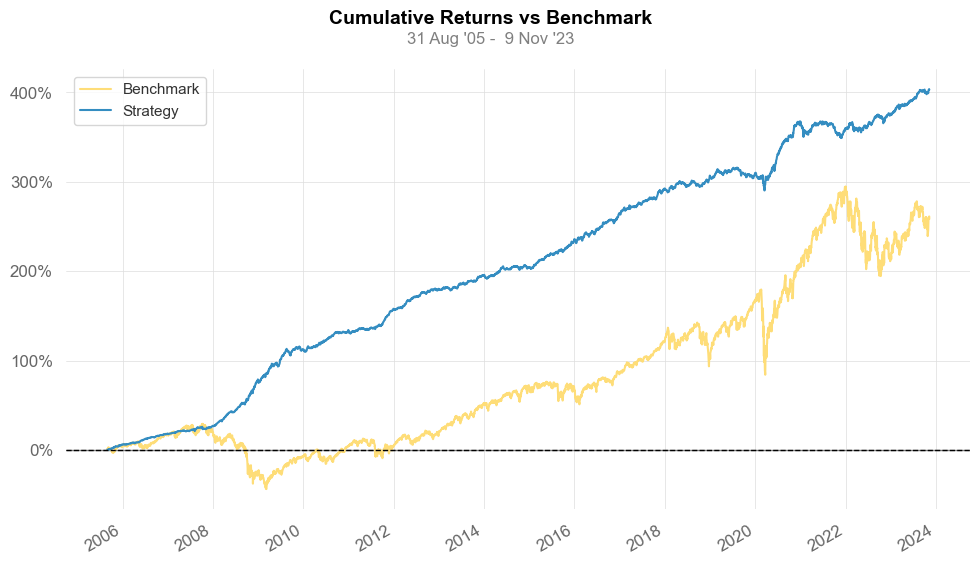

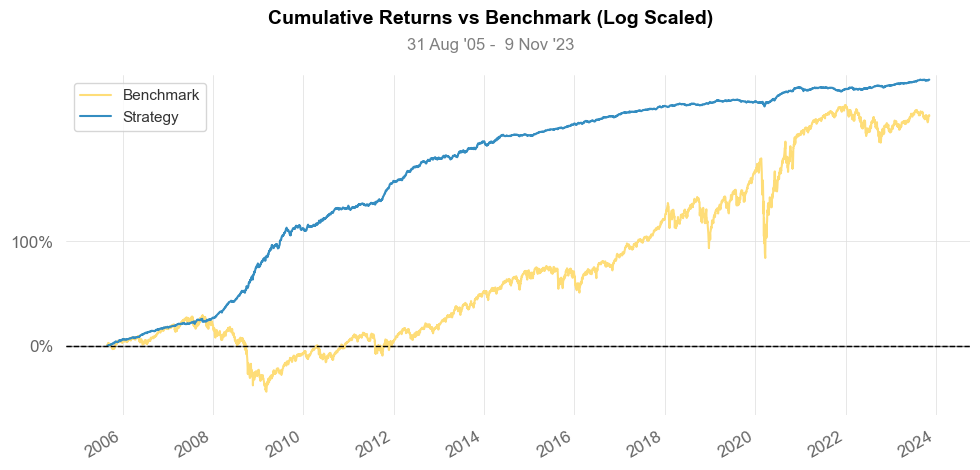

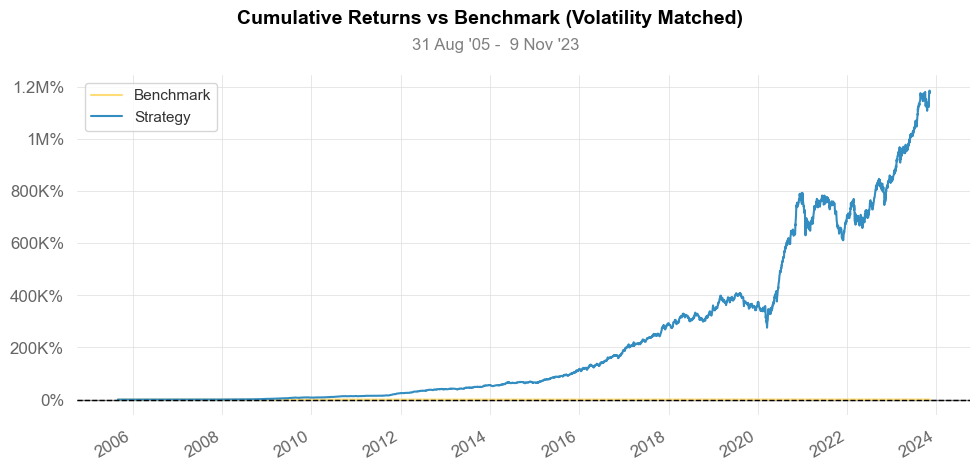

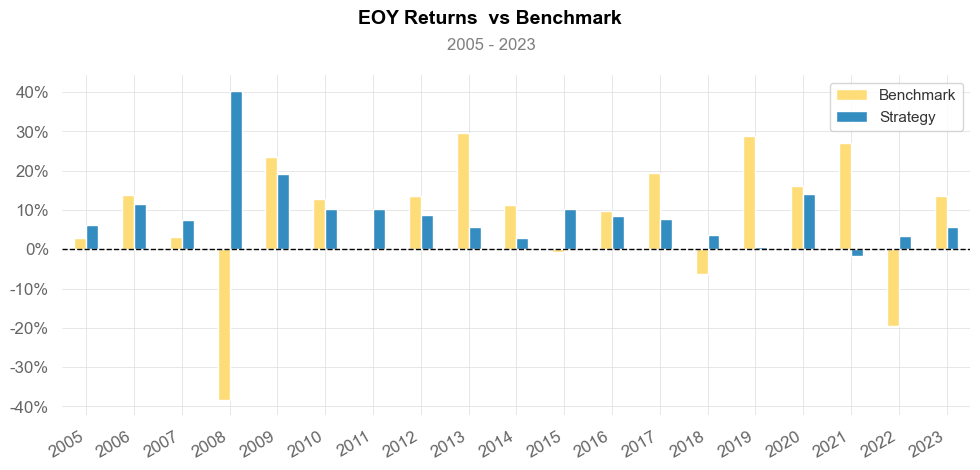

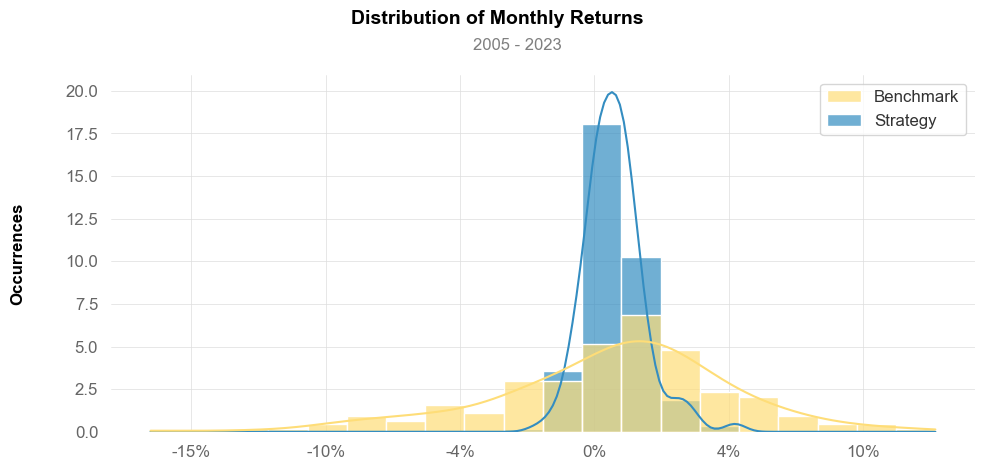

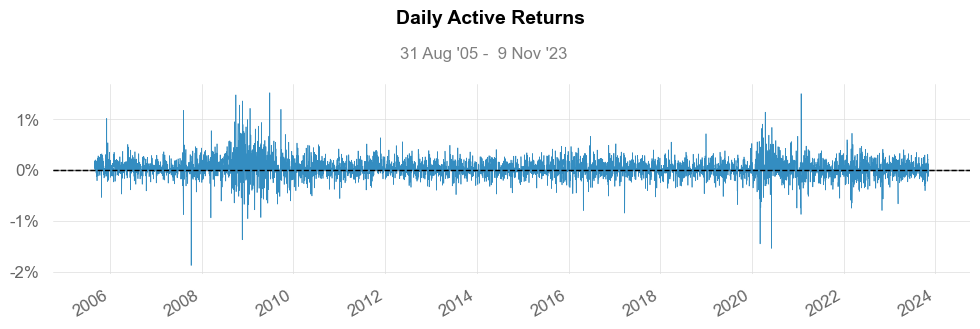

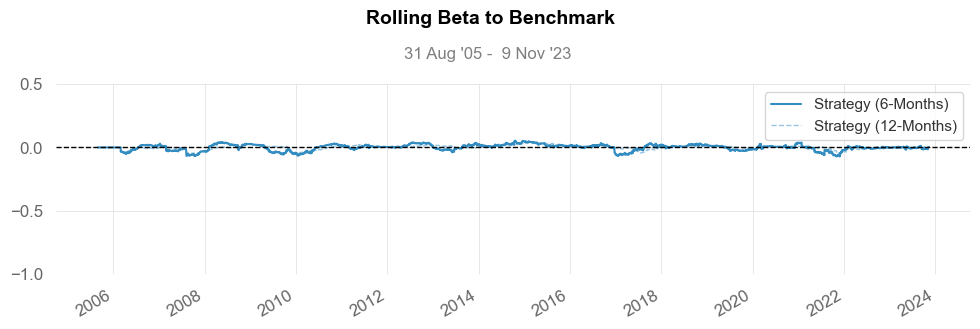

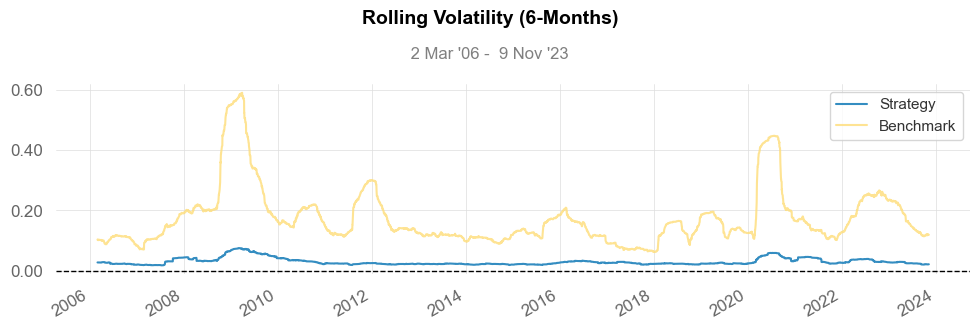

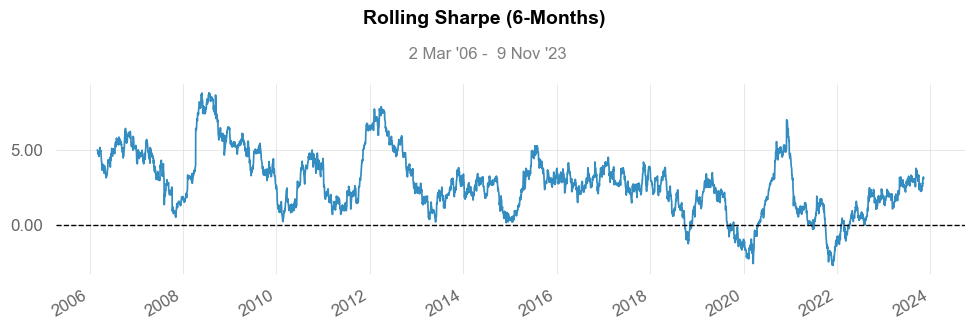

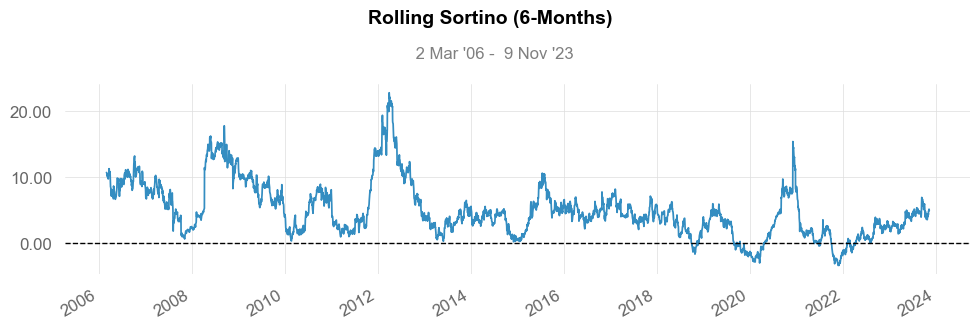

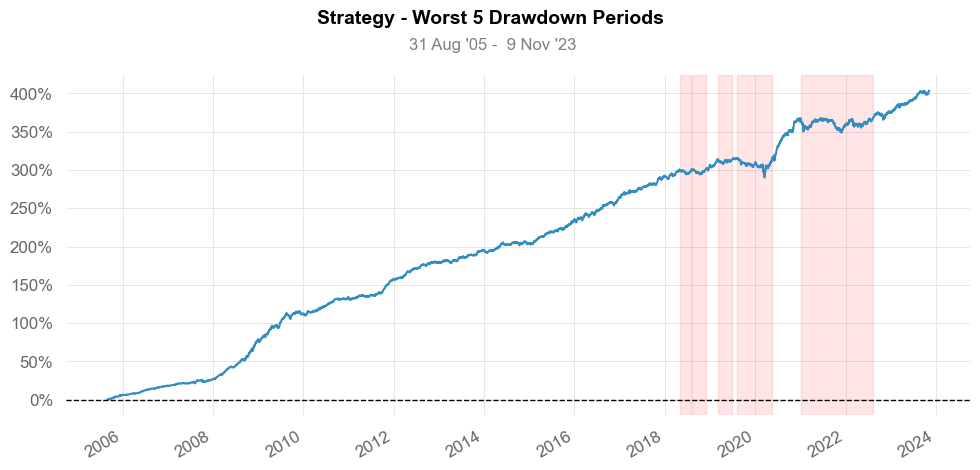

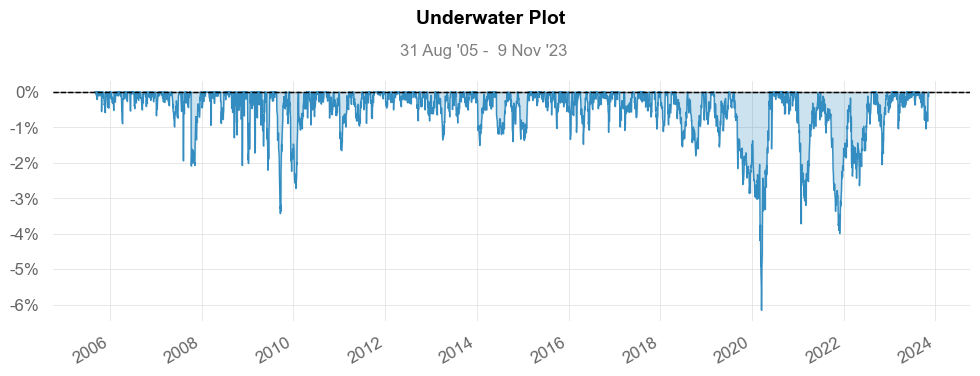

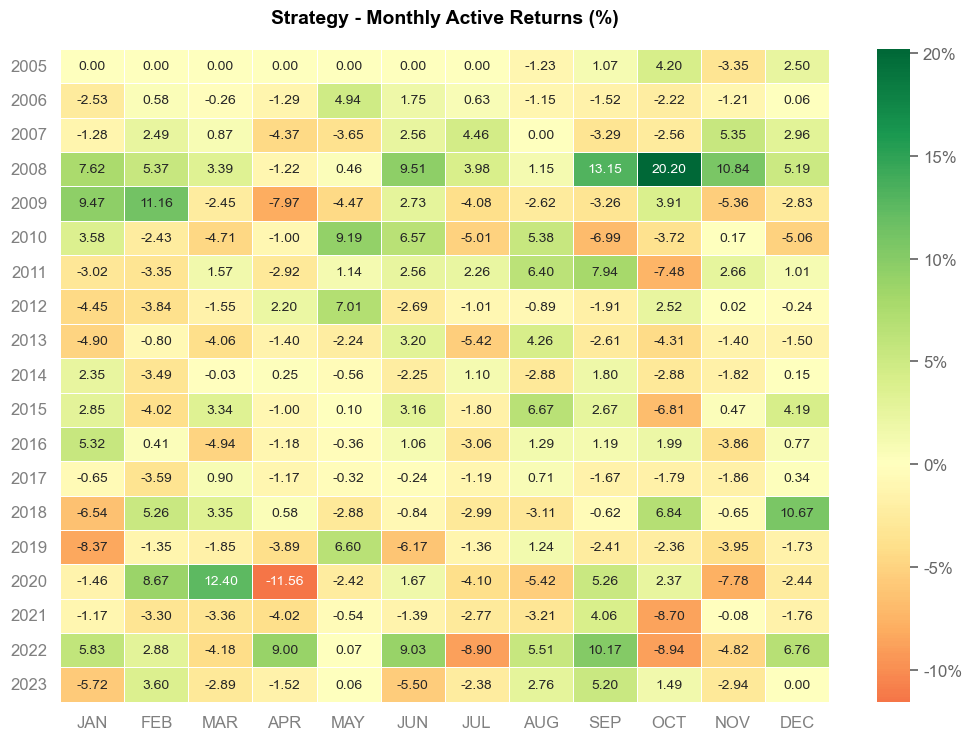

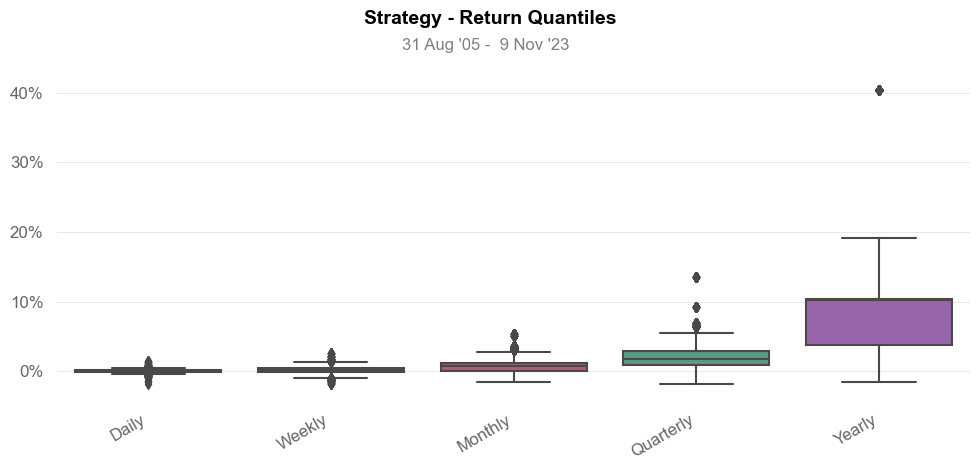

In [30]:
# Plot Results
spy = get_spy(start_date='2005-01-01', end_date=current_date)
qs.reports.full(ewp_ret, spy, figsize=(10, 5))

In [329]:
# stock_weight.to_parquet(get_strategy_mrev_etf_data() / 'data_stock_etf.parquet.brotli', compression='brotli')
# beta_weight.to_parquet(get_strategy_mrev_etf_data() / 'data_hedge_etf.parquet.brotli', compression='brotli')

In [330]:
# # Export data
# result_past_copy[['signal', 'position', 'market_cap']].to_parquet(get_strategy_mrev_etf_data() / 'data_signal_etf.parquet.brotli', compression='brotli')

# Live

In [331]:
# Read in ETF data from FMP
T = [1]
sector_ret_live = get_data_fmp(ticker_list=etf_list, start=start, current_date=current_date)
sector_ret_live = sector_ret_live[['Open', 'High', 'Low', 'Volume', 'Adj Close']]
sector_ret_live = sector_ret_live.rename(columns={'Adj Close': 'Close'})

# Create returns and unstack dataframe to only have 'date' index and 'ETF ticker' columns
sector_ret_live = create_return(sector_ret_live, T)
sector_ret_live = sector_ret_live.drop(['Close', 'High', 'Low', 'Open', 'Volume'], axis=1)
sector_ret_live = sector_ret_live.unstack('ticker').swaplevel(axis=1)
sector_ret_live.columns = ['_'.join(col).strip() for col in sector_ret_live.columns.values]
sector_ret_live = sector_ret_live.fillna(0)

Fetching data: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:11<00:00,  1.04ticker/s]


In [332]:
# Read in price data and set up params for Rolling LR
T = [1]
ret = f'RET_01'
live_data = pd.read_parquet(get_parquet_dir(live) / 'data_price.parquet.brotli')
factor_col_live = sector_ret_live.columns
live_data = create_return(live_data, T)
live_data = live_data.fillna(0)

In [333]:
# Function that executes the RollingOLS for the last window of data (this function will be parallelized)
def per_stock_ols_last(stock_data, ret, factor_data, factor_cols, window, stock_name, index_name):
    # Set up data
    model_data = stock_data[[ret]].merge(factor_data, on='date').dropna()
    model_data = model_data[[ret] + factor_cols]
    model_data = model_data.iloc[-window:]
    # Train model
    exog = sm.add_constant(model_data[factor_cols])
    model = OLS(model_data[ret], exog)
    results = model.fit()
    # Get betas
    factor_model_params = results.params.to_frame().T
    factor_model_params.rename(columns={'const': 'ALPHA'}, inplace=True)
    # Get predictions
    predicted_last = (exog.iloc[-1] * factor_model_params.iloc[-1]).sum()
    predicted_series = pd.Series(predicted_last, name='pred')
    # Compute residuals (epsilon) for the last observation
    epsilon_last = model_data[ret].iloc[-1] - predicted_last
    epsilon_series = pd.Series(epsilon_last, name='epsil')
    # Format data
    result = factor_model_params.assign(epsil=epsilon_series, pred=predicted_series)
    result = result.assign(**{index_name: stock_name}).set_index(index_name, append=True).swaplevel()
    permnos = result.index.get_level_values(0)
    new_index = pd.MultiIndex.from_product([permnos, [pd.to_datetime(current_date)]], names=['permno', 'date'])
    result.index = new_index
    return result

# Function to execute the parallelization for last window of data
def rolling_ols_last(data, ret, factor_data, factor_cols, window, name):
    valid_groups = [(name, group) for name, group in data.groupby(level='permno') if current_data(group, current_date, window)]
    print(len(valid_groups))
    tasks = [(group, ret, factor_data, factor_cols, window, permno, data.index.names[0]) for permno, group in valid_groups]
    results = Parallel(n_jobs=-1)(delayed(per_stock_ols_last)(*task) for task in tasks)
    return pd.concat(results).rename(columns=lambda x: f'{x}_{name}_{window:02}')

In [334]:
# Execute Rolling LR
beta_data_live = rolling_ols_last(data=live_data, ret=ret, factor_data=sector_ret_live, factor_cols=factor_col_live.tolist(), window=window, name=f'sector_01')
beta_data_live = beta_data_live[beta_data_live.columns[1:14]]

733


In [335]:
# Combine live beta with historical beta
beta_data_past = pd.read_parquet(get_strategy_mrev_etf_data() / 'data_beta_etf.parquet.brotli')
beta_data_live = pd.concat([beta_data_past, beta_data_live], axis=0).sort_index(level=['permno', 'date'])
beta_data_live = beta_data_live.fillna(0)

In [336]:
# Calculate rolling mean and standard deviation
rolling_mean = beta_data_live.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).mean().reset_index(level=0, drop=True)
rolling_std = beta_data_live.groupby('permno')[f'epsil_sector_01_{window:02}'].rolling(window=window).std().reset_index(level=0, drop=True)
# Calculate the rolling Z-score
beta_data_live['s_score'] = (beta_data_live[f'epsil_sector_01_{window:02}'] - rolling_mean) / rolling_std

In [337]:
# Convert ETF Dataframe to multi-index
sector_multi_live = create_multi_index(sector_ret_live, stock)
# Merge the necessary columns together into one dataframe
combined_live = beta_data_live.merge(sector_multi_live, left_index=True, right_index=True, how='left')
combined_live = combined_live.merge(live_data[['RET_01']], left_index=True, right_index=True, how='left')
signal_past = pd.read_parquet(get_strategy_mrev_etf_data() / 'data_signal_etf.parquet.brotli')
combined_live = combined_live.merge(signal_past[['signal', 'position']], left_index=True, right_index=True, how='left')
combined_live = combined_live.fillna(0)

In [338]:
# Retrieve the needed columns
ret_columns = [col for col in combined_live.columns if "RET_01" in col]
combined_live = combined_live[['s_score', 'signal', 'position'] + ret_columns]

In [357]:
# Create signals for current date data
def create_signal_live(data, sbo, sso, sbc, ssc, threshold):
    def apply_rules(group):
        if current_date in group.index.get_level_values('date'):
            # Retrieve the current date's s_score and market_cap
            current_s_score = group.iloc[-1]['s_score']
            market_cap = group.iloc[-1]['market_cap']
            # Retrieve the previous date's position
            prev_date_position = group.iloc[-2]['position']
            # Set conditions for signals and positions
            if prev_date_position == 'long':
                if current_s_score > -ssc:
                    signal = 'close long'
                    position = None
                else:
                    signal = 'hold'
                    position = 'long'
            elif prev_date_position == 'short':
                if current_s_score < sbc:
                    signal = 'close short'
                    position = None
                else:
                    signal = 'hold'
                    position = 'short'
            elif prev_date_position == None or prev_date_position==0:
                if current_s_score < -sbo and market_cap > threshold:
                    signal = 'buy to open'
                    position = 'long'
                elif current_s_score > sso and market_cap > threshold:
                    signal = 'sell to open'
                    position = 'short'
                else:
                    signal = None
                    position = None
            return pd.Series({'signal': signal, 'position': position})
        
    # Apply the rules to each permno group and get signals and positions for the current date
    signal_positions = data.groupby(level='permno').apply(apply_rules)

    # Assign the new signals and positions to the data for the current date
    for permno in signal_positions.index:
        if pd.notna(signal_positions.loc[permno, 'signal']):
            data.loc[(permno, current_date), 'signal'] = signal_positions.loc[permno, 'signal']
            data.loc[(permno, current_date), 'position'] = signal_positions.loc[permno, 'position']
    return data

In [358]:
# Create signals
combined_live_copy = combined_live.copy(deep=True)
misc = pd.read_parquet(get_parquet_dir(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
combined_live_copy = combined_live_copy.merge(misc, left_index=True, right_index=True, how='left')
result_live = create_signal_live(combined_live_copy, sbo, sso, sbc, ssc, threshold)
result_live['RET_01'] = result_live.groupby('permno')['RET_01'].shift(-1)

In [360]:
def calc_total_weight(df):
    print("Get hedge weights...")
    mask_long = df['position'] == 'long'
    mask_short = df['position'] == 'short'
    df['hedge_weight'] = np.where(mask_long, -1, np.where(mask_short, 1, 0))
    
    # Get net hedge betas
    print("Get net hedge betas...")
    beta_columns = [col for col in df.columns if '_sector_' in col]
    weighted_betas = df[beta_columns].multiply(df['hedge_weight'], axis=0)
    net_hedge_betas = weighted_betas.groupby('date').sum()
    
    # Combine and normalize weights
    print("Normalize weights...")
    df['stock_weight'] = np.where(mask_long, 1, np.where(mask_short, -1, 0))
    
    # Normalize net hedge betas and stock weights combined
    df['abs_stock_weight'] = df['stock_weight'].abs()
    combined_weights = df.groupby('date')['abs_stock_weight'].sum() + net_hedge_betas.abs().sum(axis=1)
    df['normalized_weight'] = df['stock_weight'].div(combined_weights, axis=0)
    normalized_net_hedge_betas = net_hedge_betas.div(combined_weights, axis=0)
    
    return normalized_net_hedge_betas, df[['normalized_weight']]

In [361]:
result_live_curr = result_live.loc[result_live.index.get_level_values('date')==current_date]
beta_weight, stock_weight = calc_total_weight(result_live_curr)

Get hedge weights...
Get net hedge betas...
Normalize weights...


# Get Positions

In [375]:
# Get current date dataframe
trade = result_live.loc[result_live.index.get_level_values('date') == current_date]
trade = trade.fillna(0)
trade = trade.merge(stock_weight, left_index=True, right_index=True, how='left')

In [376]:
# Get weight to invest into each ETF for current date
beta_weight.columns = [(col.split('_')[0]) for col in beta_columns]

In [377]:
# Read in ticker dataframe
ticker = pd.read_parquet(get_parquet_dir(live) / 'data_ticker.parquet.brotli')

In [378]:
# Get long positions
long = trade.loc[trade['position'].str.contains('long', na=False)]
long = long.merge(ticker, left_index=True, right_index=True, how='left')
long_ticker = list(zip(long['ticker'], long['normalized_weight']))

In [380]:
# Get short positions
short = trade.loc[trade['signal'].str.contains('short', na=False)]
short = short.merge(ticker, left_index=True, right_index=True, how='left')
short_ticker = list(zip(short['ticker'], short['normalized_weight']))

In [ ]:
def display_stock(stocks, title):
    n = len(stocks)
    cols = int(math.sqrt(2 * n))
    max_length = max([len(item[0]) for item in stocks])

    text_content = f"{title}\n"
    border_line = '+' + '-' * (max_length + 3) * cols + '+\n'

    text_content += border_line
    for i in range(n):
        text_content += f"| {stocks[i][0].center(max_length)} "
        if (i + 1) % cols == 0:
            text_content += "|\n"
            text_content += border_line
    return text_content

In [ ]:
# Display stocks to long and short tomorrow
content = display_stock(long_ticker, "Stocks to Long Today:")
content += '\n\n' + display_stock(short_ticker, "Stocks to Short Today:")
print(content)

# Append long/short stocks to dataframe and export
all_columns = ['date'] + [f'Long_{i:02}' for i in range(1, len(long) + 1)] + [f'Short_{i:02}' for i in range(1, len(short) + 1)]
stock_data = [current_date] + long_ticker + short_ticker
df_combined_stock = pd.DataFrame([stock_data], columns=all_columns)
filename_stock = Path(get_strategy_mrev_etf() / f'trade_stock_mrev_etf.csv')

etf_columns = ['date'] + [f'ETF_{i:02}' for i in range(1, len(etf_ticker) + 1)]
etf_data = [current_date] + etf_ticker
df_combined_etf = pd.DataFrame([etf_data], columns=etf_columns)
filename_etf = Path(get_strategy_mrev_etf() / f'trade_etf_mrev_etf.csv')

def update_csv_for_date(filename, df_combined, current_date):
    # Check if file exists
    if os.path.exists(filename):
        existing_df = pd.read_csv(filename)
        # Check if the current_date already exists in the existing_df
        if current_date in existing_df['date'].values:
            existing_df = existing_df[existing_df['date'] != current_date]
        updated_df = pd.concat([existing_df, df_combined], ignore_index=True)
        updated_df.to_csv(filename, index=False)
    else:
        df_combined.to_csv(filename, index=False)

# Assuming df_combined_stock and df_combined_etf are your dataframes for stock and ETF respectively
# and filename_stock and filename_etf are the corresponding filenames for stock and ETF data
update_csv_for_date(filename_stock, df_combined_stock, current_date)
update_csv_for_date(filename_etf, df_combined_etf, current_date)